# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении есть набор фотографий людей с указанием возраста. Необходимо достичь качества модели по метрике МАЕ не более 8 лет.

## Исследовательский анализ данных

In [2]:
# Загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os

from keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image 

In [3]:
# Загрузка данных
data = pd.read_csv('/datasets/faces/' + 'labels.csv')
data.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
# Отобразим базовую статистику
print("Первые 5 записей:")
print(data.head())
print("\nОбщая информация о датасете:")
print(data.info())
print("\nСтатистика по возрасту:")
print(data['real_age'].describe())

Первые 5 записей:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Статистика по возрасту:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


Датасет содержит информацию о названии файлов с фотографиями людей и их возрастом на момент съемки. Содержит 7591 строку. Средний возраст составляет 31 год, минимальный возраст 1 год, а максимальный - 100 лет.

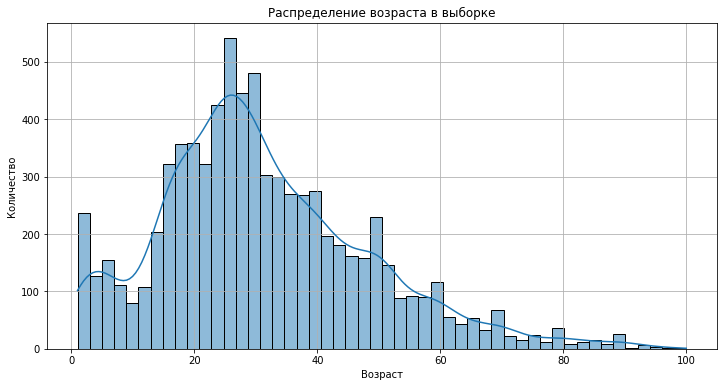

In [5]:
# Визуализация распределения возрастов
plt.figure(figsize=(12, 6))
sns.histplot(data['real_age'], bins=50, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

Распределение возрастов в наборе данных демонстрирует характеристики нормального распределения. Имеется аномальный всплеск значений в младшей возрастной группе. Асимметрия распределения выражена смещением вершины колокола влево, при этом модальный интервал (наиболее часто встречающиеся значения) приходится на возраст 25–30 лет. Медианное значение составляет 29 лет, что также подтверждает смещение распределения. Также наблюдаются всплески в интервалах значений кратных 5 годам, возможно имеет место округление значений возраста.

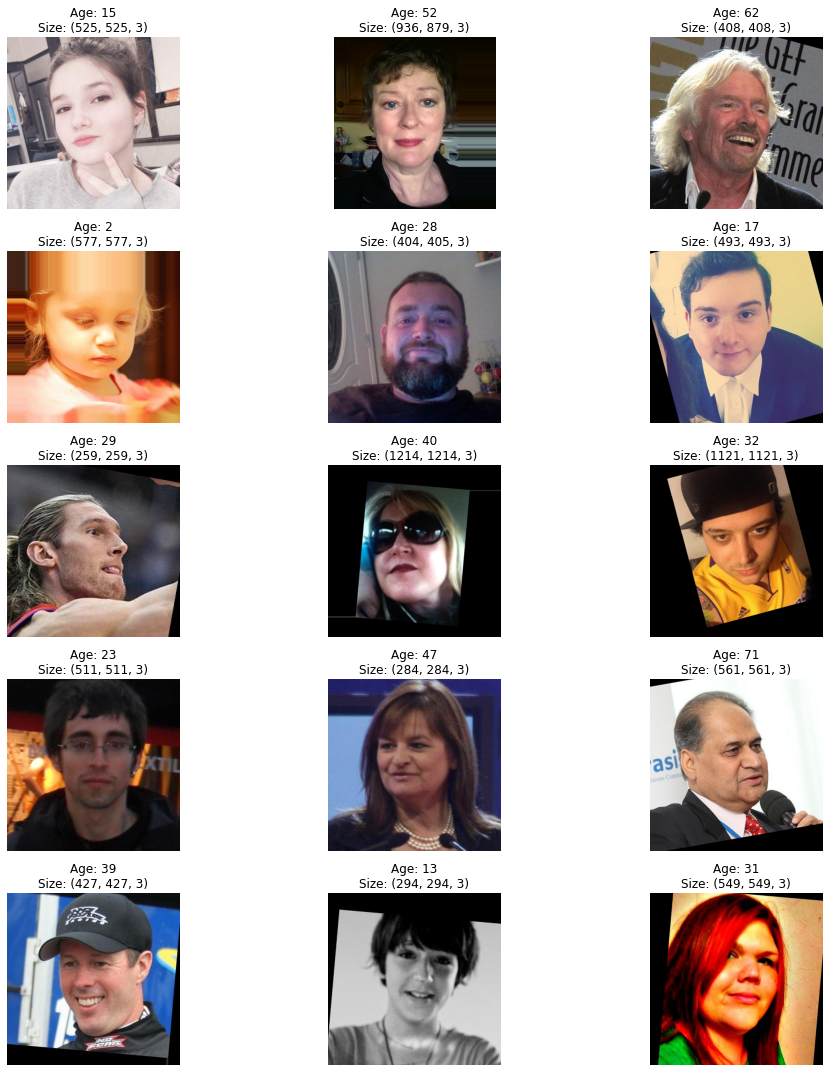

In [6]:
# Выведем 15 случайных фото и информацией о возрасте и размерности
FACES_DIR = '/datasets/faces/'
NUM_IMAGES = 15
# Выбираем 15 случайных индексов
random_indices = data.sample(n=NUM_IMAGES).index

# Функция для открытия изображения
def load_image(file_name):
    file_path = os.path.join(FACES_DIR, 'final_files', file_name)
    return Image.open(file_path)

plt.figure(figsize=(15, 15))  

# Вывод случайных изображений
for idx, i in enumerate(random_indices):
        
    file_name = data.loc[i, 'file_name']
    age = data.loc[i, 'real_age']

    image = load_image(file_name)
    array = np.array(image)

    plt.subplot(5, 3, idx + 1)  
    plt.imshow(array)
    plt.title(f"Age: {age}\nSize: {array.shape}")
    plt.axis('off')

plt.tight_layout()  
plt.show()

Выводы исследовательского анализа.

Формат предоставленных данных: JPG-изображения с тремя цветовыми каналами (RGB). По структуре - это квадратные по форме изображения с различной размерностью. В единой директории содержатся фотографии людей разных возрастов и полов, снятые при различных условиях освещения и на разных фонах. Попадаются фотографии известных, менее известных, а также обычных людей. Следовательно, данные собраны из абсолютно различных источников.

Из особенностей изображений стоит отметить, что в целом лица выровнены вертикально и занимают значительную часть кадра, из-за чего местами есть черный фон по краям после обрезки.

Качество разметки корректное, несоответствий указанных возрастов реальным не наблюдается.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# Загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os

from keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image 
# Функция подготовки тренировочных данных
def load_train(path):

    datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 30,
        height_shift_range = 30,
        zoom_range = [0.8, 0.8],
        horizontal_flip = True, 
        rescale=1./255,
        validation_split=0.2
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'), 
        #labels='inferred', 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return datagen_flow
# Функция подготовки тестовых данных
def load_test(path):

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv') ,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return datagen_flow
# Функция создания модели 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])

    model.summary() 

    return model
# Функция обучения модели 
def train_model(model,train_datagen_flow, 
                test_datagen_flow, 
                batch_size=None, epochs=10, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'keras.engine.sequential.Sequential'>
Epoch 1/10
 - 115s - loss: 827.4968 - mean_absolute_error: 23.8327 - val_loss: 1172.1111 - val_mean_absolute_error: 29.6162
Epoch 2/10
 - 94s - loss: 278.1283 - mean_absolute_error: 12.5285 - val_loss: 1059.5555 - val_mean_absolute_error: 29.6162
Epoch 3/10
 - 99s - loss: 156.1933 - mean_absolute_error: 9.2808 - val_loss: 992.2441 - val_mean_absolute_error: 27.2921
Epoch 4/10
 - 98s - loss: 121.9110 - mean_absolute_error: 8.2395 - val_loss: 205.8949 - val_mean_absolute_error: 10.6615
Epoch 5/10
 - 101s - loss: 101.8623 - mean_absolute_error: 7.5280 - val_loss: 65.0802 - val_mean_absolute_error: 7.6214
Epoch 6/10
 - 99s - loss: 92.7203 - mean_absolute_error: 7.3123 - val_loss: 178.8136 - val_mean_absolute_error: 7.5586
Epoch 7/10
 - 100s - loss: 87.7826 - mean_absolute_error: 7.0242 - val_loss: 84.4862 - val_mean_absolute_error: 7.1205
Epoch 8/10
 - 99s - loss: 77.6537 - mean_absolute_error: 6.6999 - val_loss: 105.6825 - val_mean_absolute_error: 7.5460
Epoch 9/10
 - 99s - loss: 77.3244 - mean_absolute_error: 6.6763 - val_loss: 50.5644 - val_mean_absolute_error: 7.2416
Epoch 10/10
 - 100s - loss: 67.4840 - mean_absolute_error: 6.2823 - val_loss: 81.3351 - val_mean_absolute_error: 6.8835
Test MAE: 6.8835

Задание выполнено верно


```

## Анализ обученной модели

Обученная нами модель достигла на валидационных данных значения метрики МАЕ = 6.8835, что удовлетворяет условиям задачи МАЕ < 8.
Это означает что в предсказании возраста модель в среднем ошибается на 6.9 лет. 
<BR>Таким образом, данная модель может применятся для определения возрастной группы покупателя с целью анализа их покупок и таргетированных для этой группы предложений (товаров и услуг). 
    <BR>Однако, данная модель не рекомендуется к применению для задач контроля кассиров при продаже алкоголя ввиду неприемлевого уровня ошибки при определения возраста покупателя.